In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('/net/fs11/d0/emfreese/social_cost_carbon/tsd_2021_all_mc_runs.csv', header = [0,1,2,3,4], index_col = 0)
df = df.transpose()  #data is in 2007$/metric ton
df = df.droplevel(['Model','Scenario']).xs('2020')

#### read in emissions data ####
gmodel_egrid = xr.open_zarr(f'./final_data/gmodel_egrid_emissions_ds.zarr')


d = {'baseline': [135, 177, 258, 414, 789], 'optimal': [91, 110, 158, 221, 430]}
df_bressler_SCC = pd.DataFrame(data=d, index=pd.Index(['low', 'central','high']))


In [3]:
d = {'SCC': [80, 118, 185, 308]}
df_rennert_SCC = pd.DataFrame(data=d, index=pd.Index(['3.0%','2.5%','2.0%','1.5%']))*0.8 #discount to 2007 dollars


In [4]:
#### CO2 values ####
normal_CO2 = ((gmodel_egrid.sel(model_name = 'normal_model')['PLCO2RTA']*gmodel_egrid.sel(model_name = 'normal_model')['annual_modelgeneration']).sum()*.001).values #metric tons
nonuc_CO2 = ((gmodel_egrid.sel(model_name = 'nonuc_model')['PLCO2RTA']*gmodel_egrid.sel(model_name = 'nonuc_model')['annual_modelgeneration']).sum()*.001).values #metric tons
nonuc_coal_CO2 = ((gmodel_egrid.sel(model_name = 'nonuc_nocoal_model')['PLCO2RTA']*gmodel_egrid.sel(model_name = 'nonuc_nocoal_model')['annual_modelgeneration']).sum()*.001).values #metric tons
nonuc_renew_CO2 = ((gmodel_egrid.sel(model_name = 'nonuc_renewables_model')['PLCO2RTA']*gmodel_egrid.sel(model_name = 'nonuc_renewables_model')['annual_modelgeneration']).sum()*.001).values #metric tons

dif_nuc_CO2 = nonuc_CO2 - normal_CO2
dif_coal_CO2 = nonuc_coal_CO2 - normal_CO2
dif_renew_CO2 = nonuc_renew_CO2 - normal_CO2

In [5]:
#### datasets for normal and no nuclear cost of CO2 emissions ####
df_nonuc = (df*nonuc_CO2)
df_normal = (df*normal_CO2)
df_nonuc_coal = (df*nonuc_coal_CO2)
df_nonuc_renew = (df*nonuc_renew_CO2)

df_nonuc_dif = (df*dif_nuc_CO2)
df_nonuc_coal_dif = (df*dif_coal_CO2)
df_nonuc_renew_dif = (df*dif_renew_CO2)

/tmp/ipykernel_3309357/2315478151.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  x = df.loc[(scc, 'CO2')].values.flatten()*1e-9 #drop the levels for model, scenario type, choose 2010 levels
/tmp/ipykernel_3309357/2315478151.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


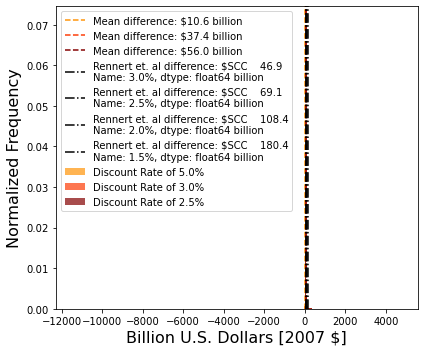

In [10]:
#### plot our SCC by discount rate ####
colors = ["tangerine","red orange",'dark red']
#colors_mean = ["light blue","twilight blue",'navy']
bin_vals = [100.,1000.]
co2_dict = {'nonuc':dif_nuc_CO2,'nonuc_coal':dif_coal_CO2,'nonuc_renew':dif_renew_CO2}
for df, nm in zip([df_nonuc_dif, df_nonuc_coal_dif, df_nonuc_renew_dif],['nonuc','nonuc_coal','nonuc_renew']):
    fig, axes = plt.subplots(1,1, figsize=[6,5],)
    for idx_c, scc in enumerate(['5.0%','3.0%','2.5%']):
        x = df.loc[(scc, 'CO2')].values.flatten()*1e-9 #drop the levels for model, scenario type, choose 2010 levels
        mean = x.mean()
        n, bins, patches = plt.hist(x=x, bins='auto', color=sns.xkcd_palette(colors)[idx_c],label = f'Discount Rate of {scc}',
                                alpha=0.7, density = True)
        plt.axvline(mean, color=sns.xkcd_palette(colors)[idx_c], linestyle='--', label = f'Mean difference: ${np.round(mean,1)} billion')
        plt.legend()
        #plt.title(f'Monetized Social Impact', fontsize = 20)
        plt.xlabel('Billion U.S. Dollars [2007 $]', fontsize = 16)
        plt.ylabel('Normalized Frequency', fontsize = 16)
        plt.xlim(-20,150)
    for idx_c, scc in enumerate(['3.0%','2.5%','2.0%','1.5%']): 
        rennert_est = (co2_dict[nm]*df_rennert_SCC).loc[scc]*1e-9
        plt.axvline(rennert_est.values, color='k', linestyle='-.', label = f'Rennert et. al difference: ${np.round(rennert_est,1)} billion')
        plt.legend()
    plt.tight_layout()
    plt.savefig(f'Figures/scc_{nm}.png', dpi = 150, bbox_inches = 'tight')


## Mortality Cost Carbon

In [46]:
#data for carleton is from Carleton et al, supplement table H.2 and EPA VSL from table H.1
#data for bressler is from Bressler, main paper

In [47]:
d = {'baseline': [-1.71e-4, 2.26e-4, 6.78e-4], 'optimal': [-2.16e-4, 1.07e-4, 5.22e-4]}
df_bressler_MCC = pd.DataFrame(data=d, index=pd.Index(['low', 'central','high']))


In [51]:
df_bressler_MCC

,baseline,optimal
low,-0.000171,-0.000216
central,0.000226,0.000107
high,0.000678,0.000522


In [53]:
print('No Nuclear')
dif_nuc_CO2*df_bressler_MCC

No Nuclear


,baseline,optimal
low,-125220.704194,-158173.521087
central,165496.369285,78354.475724
high,496489.107856,382252.675960


In [49]:
print('No Nuclear- No Coal')
print(dif_coal_CO2*df_bressler_MCC)

No Nuclear- No Coal
             baseline       optimal
low     -16858.341030 -21294.746564
central  22280.614461  10548.786493
high     66841.843383  51462.304197


In [50]:
print('No Nuclear+ Renewables')

print(dif_renew_CO2*df_bressler_MCC)

No Nuclear+ Renewables
             baseline       optimal
low     -23774.863743 -30031.406834
central  31421.749743  14876.669126
high     94265.249228  72575.899848
